# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

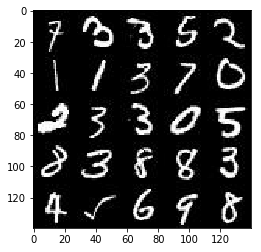

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

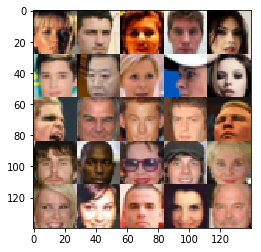

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/javiersv05/miniconda2/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(
        tf.float32,
        shape=[None, image_width, image_height, image_channels],
        name='input_real'
    )
    
    input_z = tf.placeholder(
        tf.float32,
        shape=[None, z_dim],
        name='input_z'
    )
    
    learning_rate = tf.placeholder(
        tf.float32,
        name='learning_rate'
    )

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        flat = tf.reshape(x2, (-1, 7 * 7 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
    
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real,
        labels=tf.ones_like(d_model_real),
    )
    d_loss_real = tf.reduce_mean(d_loss_real)
    
    d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake,
        labels=tf.zeros_like(d_model_fake)
    )
    d_loss_fake = tf.reduce_mean(d_loss_fake)
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake,
        labels=tf.ones_like(d_model_fake)
    )
    g_loss = tf.reduce_mean(g_loss)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Random noise to feed generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Images are in range(-0.5, 0.5) so we scale them up by two to match range(-1, 1)
                batch_images *= 2
                
                # Run optimizers
                sess.run(d_optimizer, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lr: learning_rate
                })
                
                sess.run(g_optimizer, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lr: learning_rate
                })
                
                
                # Print training loss
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                          
                
                # Show generator output so far
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 0.2754... Generator Loss: 1.7518
Epoch 1/4... Discriminator Loss: 0.1650... Generator Loss: 2.4815
Epoch 1/4... Discriminator Loss: 1.8564... Generator Loss: 2.3394
Epoch 1/4... Discriminator Loss: 0.7966... Generator Loss: 2.5249
Epoch 1/4... Discriminator Loss: 0.6234... Generator Loss: 2.0496
Epoch 1/4... Discriminator Loss: 0.6550... Generator Loss: 1.4616
Epoch 1/4... Discriminator Loss: 0.9194... Generator Loss: 1.4794
Epoch 1/4... Discriminator Loss: 0.7738... Generator Loss: 1.2462
Epoch 1/4... Discriminator Loss: 0.8681... Generator Loss: 0.7903
Epoch 1/4... Discriminator Loss: 0.8630... Generator Loss: 0.7879


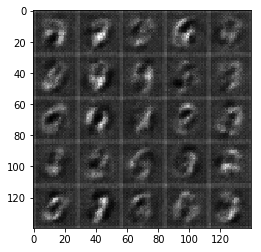

Epoch 1/4... Discriminator Loss: 1.0879... Generator Loss: 2.0853
Epoch 1/4... Discriminator Loss: 1.2823... Generator Loss: 0.4219
Epoch 1/4... Discriminator Loss: 0.8928... Generator Loss: 1.6177
Epoch 1/4... Discriminator Loss: 0.8705... Generator Loss: 0.7843
Epoch 1/4... Discriminator Loss: 1.0522... Generator Loss: 2.0971
Epoch 1/4... Discriminator Loss: 0.8634... Generator Loss: 0.8378
Epoch 1/4... Discriminator Loss: 1.2122... Generator Loss: 0.4364
Epoch 1/4... Discriminator Loss: 1.1791... Generator Loss: 2.0207
Epoch 1/4... Discriminator Loss: 0.9323... Generator Loss: 1.7360
Epoch 1/4... Discriminator Loss: 0.9120... Generator Loss: 0.7273


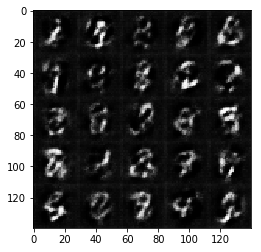

Epoch 1/4... Discriminator Loss: 0.8864... Generator Loss: 1.9898
Epoch 1/4... Discriminator Loss: 1.0715... Generator Loss: 2.3073
Epoch 1/4... Discriminator Loss: 0.8062... Generator Loss: 1.6801
Epoch 1/4... Discriminator Loss: 0.7740... Generator Loss: 1.8902
Epoch 1/4... Discriminator Loss: 0.8395... Generator Loss: 1.9040
Epoch 1/4... Discriminator Loss: 0.7205... Generator Loss: 1.0861
Epoch 1/4... Discriminator Loss: 0.6977... Generator Loss: 1.7659
Epoch 1/4... Discriminator Loss: 0.7073... Generator Loss: 1.8349
Epoch 1/4... Discriminator Loss: 0.6494... Generator Loss: 1.1747
Epoch 1/4... Discriminator Loss: 0.7679... Generator Loss: 0.8741


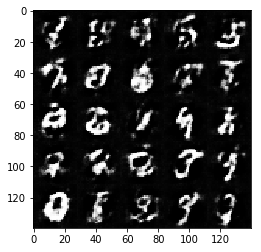

Epoch 1/4... Discriminator Loss: 0.7338... Generator Loss: 1.0089
Epoch 1/4... Discriminator Loss: 0.7726... Generator Loss: 0.8829
Epoch 1/4... Discriminator Loss: 0.7266... Generator Loss: 0.9072
Epoch 1/4... Discriminator Loss: 0.7195... Generator Loss: 2.1420
Epoch 1/4... Discriminator Loss: 0.6803... Generator Loss: 0.9938
Epoch 1/4... Discriminator Loss: 0.6252... Generator Loss: 1.4191
Epoch 1/4... Discriminator Loss: 0.6726... Generator Loss: 1.1469
Epoch 1/4... Discriminator Loss: 0.5604... Generator Loss: 2.0126
Epoch 1/4... Discriminator Loss: 0.6999... Generator Loss: 2.1293
Epoch 1/4... Discriminator Loss: 0.6014... Generator Loss: 1.1970


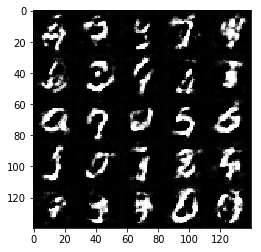

Epoch 1/4... Discriminator Loss: 0.6174... Generator Loss: 1.8302
Epoch 1/4... Discriminator Loss: 0.6124... Generator Loss: 1.4060
Epoch 1/4... Discriminator Loss: 0.5516... Generator Loss: 1.9361
Epoch 1/4... Discriminator Loss: 0.8181... Generator Loss: 0.7759
Epoch 1/4... Discriminator Loss: 0.6189... Generator Loss: 1.4357
Epoch 1/4... Discriminator Loss: 0.6600... Generator Loss: 1.2412
Epoch 2/4... Discriminator Loss: 0.6260... Generator Loss: 1.8443
Epoch 2/4... Discriminator Loss: 0.7365... Generator Loss: 0.9046
Epoch 2/4... Discriminator Loss: 0.6370... Generator Loss: 1.5555
Epoch 2/4... Discriminator Loss: 0.6254... Generator Loss: 1.2067


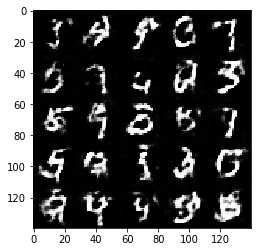

Epoch 2/4... Discriminator Loss: 0.9656... Generator Loss: 0.6470
Epoch 2/4... Discriminator Loss: 0.7301... Generator Loss: 0.9685
Epoch 2/4... Discriminator Loss: 0.6164... Generator Loss: 1.4689
Epoch 2/4... Discriminator Loss: 0.6228... Generator Loss: 2.0417
Epoch 2/4... Discriminator Loss: 0.6498... Generator Loss: 1.0969
Epoch 2/4... Discriminator Loss: 0.8615... Generator Loss: 0.7580
Epoch 2/4... Discriminator Loss: 0.7924... Generator Loss: 0.9025
Epoch 2/4... Discriminator Loss: 0.7242... Generator Loss: 2.1506
Epoch 2/4... Discriminator Loss: 0.6944... Generator Loss: 1.1213
Epoch 2/4... Discriminator Loss: 0.6706... Generator Loss: 1.6557


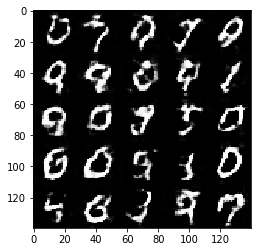

Epoch 2/4... Discriminator Loss: 0.7934... Generator Loss: 0.8983
Epoch 2/4... Discriminator Loss: 0.7251... Generator Loss: 1.8594
Epoch 2/4... Discriminator Loss: 0.6796... Generator Loss: 1.4817
Epoch 2/4... Discriminator Loss: 0.7672... Generator Loss: 1.3977
Epoch 2/4... Discriminator Loss: 0.9022... Generator Loss: 0.7735
Epoch 2/4... Discriminator Loss: 0.8242... Generator Loss: 1.7050
Epoch 2/4... Discriminator Loss: 0.8498... Generator Loss: 1.6942
Epoch 2/4... Discriminator Loss: 0.8002... Generator Loss: 1.1057
Epoch 2/4... Discriminator Loss: 0.9640... Generator Loss: 0.6891
Epoch 2/4... Discriminator Loss: 1.0190... Generator Loss: 2.1216


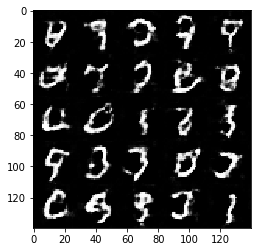

Epoch 2/4... Discriminator Loss: 0.7908... Generator Loss: 1.3688
Epoch 2/4... Discriminator Loss: 0.9666... Generator Loss: 1.9182
Epoch 2/4... Discriminator Loss: 0.9312... Generator Loss: 0.7291
Epoch 2/4... Discriminator Loss: 0.8408... Generator Loss: 1.8316
Epoch 2/4... Discriminator Loss: 0.8507... Generator Loss: 1.2513
Epoch 2/4... Discriminator Loss: 1.0218... Generator Loss: 1.9319
Epoch 2/4... Discriminator Loss: 0.8113... Generator Loss: 1.4238
Epoch 2/4... Discriminator Loss: 0.8075... Generator Loss: 1.0311
Epoch 2/4... Discriminator Loss: 0.7990... Generator Loss: 1.0921
Epoch 2/4... Discriminator Loss: 1.1736... Generator Loss: 0.5733


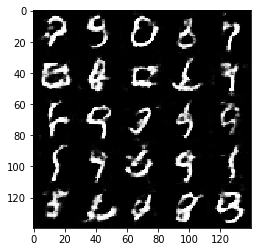

Epoch 2/4... Discriminator Loss: 0.8582... Generator Loss: 0.9161
Epoch 2/4... Discriminator Loss: 1.0260... Generator Loss: 0.6256
Epoch 2/4... Discriminator Loss: 0.8043... Generator Loss: 1.3507
Epoch 2/4... Discriminator Loss: 0.9259... Generator Loss: 0.9651
Epoch 2/4... Discriminator Loss: 0.8742... Generator Loss: 1.1824
Epoch 2/4... Discriminator Loss: 1.0942... Generator Loss: 2.3530
Epoch 2/4... Discriminator Loss: 0.8669... Generator Loss: 0.9396
Epoch 2/4... Discriminator Loss: 0.8383... Generator Loss: 1.7474
Epoch 2/4... Discriminator Loss: 0.9439... Generator Loss: 0.7454
Epoch 2/4... Discriminator Loss: 0.8250... Generator Loss: 1.3746


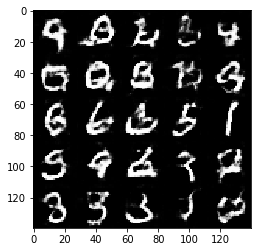

Epoch 2/4... Discriminator Loss: 0.9344... Generator Loss: 0.7304
Epoch 2/4... Discriminator Loss: 0.8226... Generator Loss: 0.8591
Epoch 2/4... Discriminator Loss: 1.3157... Generator Loss: 0.4088
Epoch 3/4... Discriminator Loss: 0.7729... Generator Loss: 1.1256
Epoch 3/4... Discriminator Loss: 0.8459... Generator Loss: 0.9209
Epoch 3/4... Discriminator Loss: 0.7591... Generator Loss: 1.3136
Epoch 3/4... Discriminator Loss: 0.7685... Generator Loss: 1.0132
Epoch 3/4... Discriminator Loss: 0.7837... Generator Loss: 1.0327
Epoch 3/4... Discriminator Loss: 0.8255... Generator Loss: 1.0069
Epoch 3/4... Discriminator Loss: 0.7138... Generator Loss: 1.3863


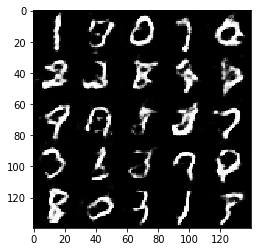

Epoch 3/4... Discriminator Loss: 1.1821... Generator Loss: 2.4959
Epoch 3/4... Discriminator Loss: 0.7476... Generator Loss: 1.3114
Epoch 3/4... Discriminator Loss: 0.8240... Generator Loss: 1.7713
Epoch 3/4... Discriminator Loss: 0.7468... Generator Loss: 1.4672
Epoch 3/4... Discriminator Loss: 0.7315... Generator Loss: 1.5906
Epoch 3/4... Discriminator Loss: 0.9510... Generator Loss: 0.6653
Epoch 3/4... Discriminator Loss: 0.9232... Generator Loss: 1.0119
Epoch 3/4... Discriminator Loss: 0.8172... Generator Loss: 1.1445
Epoch 3/4... Discriminator Loss: 0.8533... Generator Loss: 0.8418
Epoch 3/4... Discriminator Loss: 0.7489... Generator Loss: 1.2464


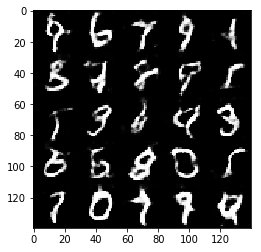

Epoch 3/4... Discriminator Loss: 0.7460... Generator Loss: 1.1607
Epoch 3/4... Discriminator Loss: 0.7742... Generator Loss: 1.0403
Epoch 3/4... Discriminator Loss: 0.7115... Generator Loss: 1.3756
Epoch 3/4... Discriminator Loss: 0.8192... Generator Loss: 0.9740
Epoch 3/4... Discriminator Loss: 0.7801... Generator Loss: 0.9563
Epoch 3/4... Discriminator Loss: 1.0014... Generator Loss: 0.6056
Epoch 3/4... Discriminator Loss: 0.8956... Generator Loss: 1.7042
Epoch 3/4... Discriminator Loss: 0.7175... Generator Loss: 1.2732
Epoch 3/4... Discriminator Loss: 0.7423... Generator Loss: 1.0491
Epoch 3/4... Discriminator Loss: 0.8287... Generator Loss: 1.1810


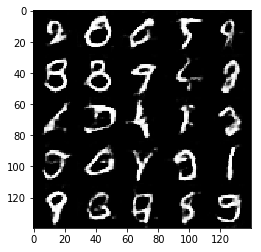

Epoch 3/4... Discriminator Loss: 0.9499... Generator Loss: 0.7006
Epoch 3/4... Discriminator Loss: 0.7595... Generator Loss: 1.0183
Epoch 3/4... Discriminator Loss: 1.0045... Generator Loss: 0.6300
Epoch 3/4... Discriminator Loss: 1.6694... Generator Loss: 0.4119
Epoch 3/4... Discriminator Loss: 0.8135... Generator Loss: 1.4691
Epoch 3/4... Discriminator Loss: 0.8749... Generator Loss: 0.8855
Epoch 3/4... Discriminator Loss: 0.7106... Generator Loss: 1.2361
Epoch 3/4... Discriminator Loss: 0.9275... Generator Loss: 0.6813
Epoch 3/4... Discriminator Loss: 0.7055... Generator Loss: 1.0706
Epoch 3/4... Discriminator Loss: 1.4512... Generator Loss: 2.7864


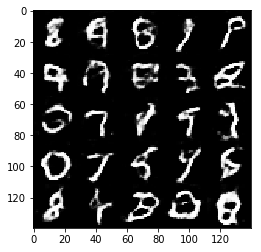

Epoch 3/4... Discriminator Loss: 0.8525... Generator Loss: 0.9231
Epoch 3/4... Discriminator Loss: 0.7787... Generator Loss: 1.1270
Epoch 3/4... Discriminator Loss: 0.7622... Generator Loss: 1.1399
Epoch 3/4... Discriminator Loss: 0.7349... Generator Loss: 1.0342
Epoch 3/4... Discriminator Loss: 0.7788... Generator Loss: 1.5582
Epoch 3/4... Discriminator Loss: 0.8992... Generator Loss: 0.7369
Epoch 3/4... Discriminator Loss: 0.9781... Generator Loss: 0.6674
Epoch 3/4... Discriminator Loss: 0.9721... Generator Loss: 0.7061
Epoch 3/4... Discriminator Loss: 0.8030... Generator Loss: 0.9217
Epoch 3/4... Discriminator Loss: 0.6854... Generator Loss: 1.4024


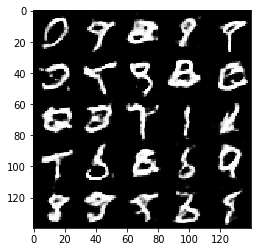

Epoch 4/4... Discriminator Loss: 0.6708... Generator Loss: 1.4353
Epoch 4/4... Discriminator Loss: 1.0493... Generator Loss: 0.5609
Epoch 4/4... Discriminator Loss: 0.9034... Generator Loss: 0.6876
Epoch 4/4... Discriminator Loss: 0.9766... Generator Loss: 1.5087
Epoch 4/4... Discriminator Loss: 0.7963... Generator Loss: 1.4134
Epoch 4/4... Discriminator Loss: 0.7544... Generator Loss: 1.3124
Epoch 4/4... Discriminator Loss: 0.7222... Generator Loss: 1.1083
Epoch 4/4... Discriminator Loss: 0.7240... Generator Loss: 1.5044
Epoch 4/4... Discriminator Loss: 0.7090... Generator Loss: 1.6298
Epoch 4/4... Discriminator Loss: 0.7076... Generator Loss: 1.2197


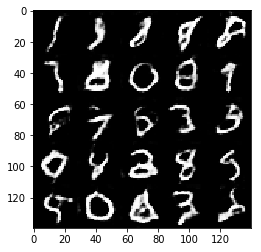

Epoch 4/4... Discriminator Loss: 0.7254... Generator Loss: 1.5898
Epoch 4/4... Discriminator Loss: 0.8670... Generator Loss: 1.6960
Epoch 4/4... Discriminator Loss: 0.7275... Generator Loss: 1.1450
Epoch 4/4... Discriminator Loss: 0.7092... Generator Loss: 1.2495
Epoch 4/4... Discriminator Loss: 0.6790... Generator Loss: 1.7419
Epoch 4/4... Discriminator Loss: 0.7964... Generator Loss: 0.9198
Epoch 4/4... Discriminator Loss: 0.7034... Generator Loss: 2.0049
Epoch 4/4... Discriminator Loss: 0.7400... Generator Loss: 1.7629
Epoch 4/4... Discriminator Loss: 0.5701... Generator Loss: 1.6064
Epoch 4/4... Discriminator Loss: 0.9738... Generator Loss: 2.6243


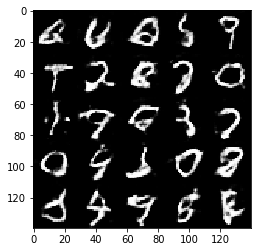

Epoch 4/4... Discriminator Loss: 0.6441... Generator Loss: 1.5831
Epoch 4/4... Discriminator Loss: 0.6687... Generator Loss: 1.0515
Epoch 4/4... Discriminator Loss: 0.6417... Generator Loss: 1.3691
Epoch 4/4... Discriminator Loss: 0.8285... Generator Loss: 0.7621
Epoch 4/4... Discriminator Loss: 0.8878... Generator Loss: 2.0909
Epoch 4/4... Discriminator Loss: 0.6522... Generator Loss: 1.0769
Epoch 4/4... Discriminator Loss: 0.9114... Generator Loss: 0.6743
Epoch 4/4... Discriminator Loss: 1.2409... Generator Loss: 0.7332
Epoch 4/4... Discriminator Loss: 0.9485... Generator Loss: 0.9204
Epoch 4/4... Discriminator Loss: 0.7532... Generator Loss: 1.0955


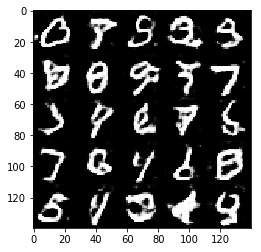

Epoch 4/4... Discriminator Loss: 0.8778... Generator Loss: 0.8166
Epoch 4/4... Discriminator Loss: 0.9215... Generator Loss: 1.9663
Epoch 4/4... Discriminator Loss: 0.8073... Generator Loss: 0.9373
Epoch 4/4... Discriminator Loss: 0.6795... Generator Loss: 1.1435
Epoch 4/4... Discriminator Loss: 0.6881... Generator Loss: 1.5439
Epoch 4/4... Discriminator Loss: 0.6650... Generator Loss: 1.1503
Epoch 4/4... Discriminator Loss: 0.7725... Generator Loss: 0.9305
Epoch 4/4... Discriminator Loss: 0.7161... Generator Loss: 1.0298
Epoch 4/4... Discriminator Loss: 0.8778... Generator Loss: 0.7704
Epoch 4/4... Discriminator Loss: 0.8750... Generator Loss: 1.7886


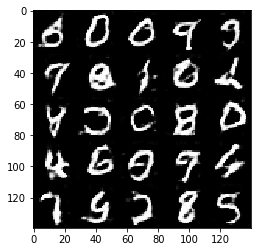

Epoch 4/4... Discriminator Loss: 0.7779... Generator Loss: 0.8994
Epoch 4/4... Discriminator Loss: 0.6565... Generator Loss: 1.2144
Epoch 4/4... Discriminator Loss: 0.6992... Generator Loss: 0.9975
Epoch 4/4... Discriminator Loss: 0.9959... Generator Loss: 0.6185
Epoch 4/4... Discriminator Loss: 0.6880... Generator Loss: 1.1975
Epoch 4/4... Discriminator Loss: 1.0146... Generator Loss: 0.5990
Epoch 4/4... Discriminator Loss: 0.5821... Generator Loss: 1.2876


In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.